# Exercise 8: Neural Data Analysis

Based on the tutorial and GPFA implementation here: https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import quantities as pq
import neo
from elephant.spike_train_generation import inhomogeneous_poisson_process
from elephant.gpfa import GPFA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score

## Lorenz Attractor Dynamics

In [ ]:
def integrated_lorenz(dt, num_steps, x0=0, y0=1, z0=1.05, 
                      sigma=10, rho=28, beta=2.667, tau=1e3):
    """integrate lorenz system"""
    def _lorenz_ode(point, t, sigma, rho, beta, tau):
        x, y, z = point
        x_dot = (sigma*(y - x)) / tau
        y_dot = (rho*x - y - x*z) / tau
        z_dot = (x*y - beta*z) / tau
        return x_dot, y_dot, z_dot
    t = dt * np.arange(num_steps)
    trajectory = odeint(_lorenz_ode, (x0, y0, z0), t, args=(sigma, rho, beta, tau))
    return t, trajectory.T

def random_projection(data, embedding_dim, scale=None):
    """project data to lower dim space"""
    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    
    proj_matrix = np.random.normal(0, scale, (embedding_dim, data.shape[0]))
    return np.dot(proj_matrix, data)

def generate_spiketrains(rates, num_trials, timestep):
    """generate spike trains from instantaneous rates"""
    spiketrains = []
    for _ in range(num_trials):
        trial_trains = []
        for rate in rates:
            anasig = neo.AnalogSignal(rate, sampling_rate=1/timestep, units=pq.Hz)
            trial_trains.append(inhomogeneous_poisson_process(anasig))
        spiketrains.append(trial_trains)
    
    return spiketrains

## Generating Synthetic Data

In [3]:
# simulation parameters
timestep = 1 * pq.ms
transient_duration = 10 * pq.s
trial_duration = 30 * pq.s
num_steps_transient = int((transient_duration.rescale('ms')/timestep).magnitude)
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)
max_rate = 70 * pq.Hz
num_trials = 20
num_spiketrains = 50

np.random.seed(42)

# integrate lorenz system
times, lorenz_3d = integrated_lorenz(
    timestep, num_steps=num_steps_transient+num_steps, 
    x0=0, y0=1, z0=1.25
)

times = (times - transient_duration).rescale('s').magnitude
times_trial = times[num_steps_transient:]

# project to high-dimensional space
lorenz_nd = random_projection(
    lorenz_3d[:, num_steps_transient:], 
    embedding_dim=num_spiketrains
)

# convert to firing rates
normed_traj = lorenz_nd / lorenz_nd.max()
rates_lorenz = np.power(max_rate.magnitude, normed_traj)

# generate spike trains
spiketrains_lorenz = generate_spiketrains(
    rates_lorenz, num_trials, timestep
)

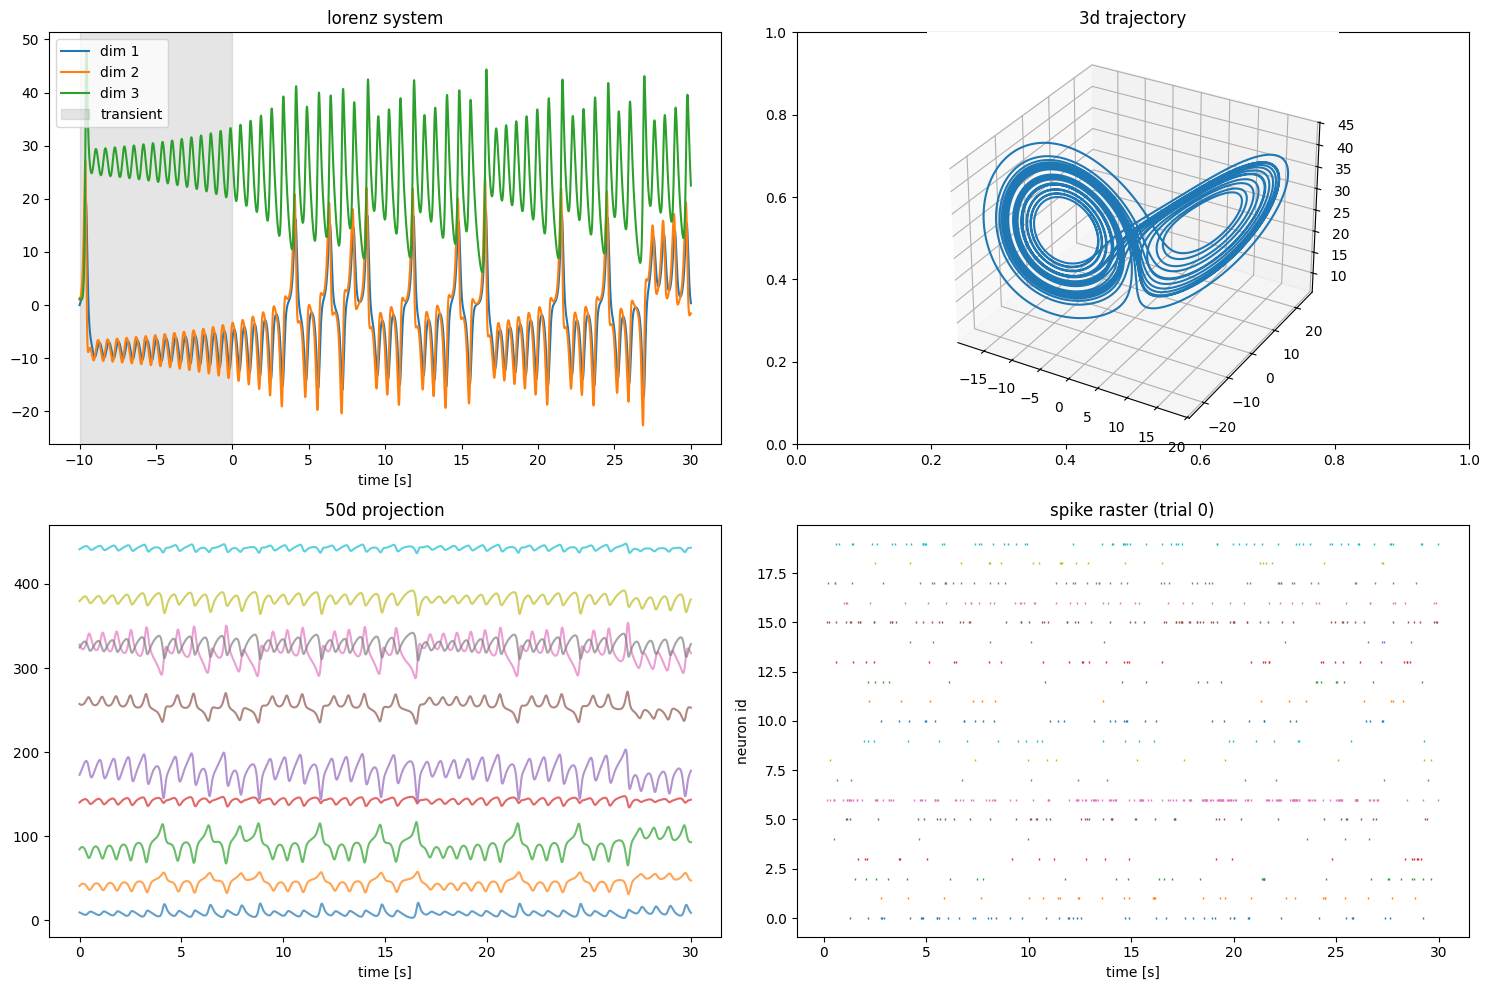

In [4]:
# visualize data generation
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# lorenz time series
ax1.set_title('lorenz system')
ax1.set_xlabel('time [s]')
for i, x in enumerate(lorenz_3d):
    ax1.plot(times, x, label=f'dim {i+1}')
ax1.axvspan(-transient_duration.rescale('s').magnitude, 0, 
           color='gray', alpha=0.2, label='transient')
ax1.legend()

# 3d trajectory  
ax2 = f.add_subplot(2, 2, 2, projection='3d')
ax2.set_title('3d trajectory')
ax2.plot(lorenz_3d[0, num_steps_transient:],
         lorenz_3d[1, num_steps_transient:],
         lorenz_3d[2, num_steps_transient:])

# high-d projection
ax3.set_title(f'{num_spiketrains}d projection')
ax3.set_xlabel('time [s]')
y_offset = lorenz_nd.std() * 3
for i in range(min(10, num_spiketrains)):
    ax3.plot(times_trial, lorenz_nd[i] + i*y_offset, alpha=0.7)

# raster plot
ax4.set_title('spike raster (trial 0)')
ax4.set_xlabel('time [s]')
ax4.set_ylabel('neuron id')
for i, train in enumerate(spiketrains_lorenz[0][:20]):  # show first 20 neurons
    ax4.plot(train, np.ones(len(train)) * i, '|', markersize=1)

plt.tight_layout()
plt.show()

## GPFA Dimensionality Reduction

In [5]:
# fit gpfa model
bin_size = 20 * pq.ms
latent_dim = 3

gpfa_model = GPFA(bin_size=bin_size, x_dim=latent_dim)
trajectories = gpfa_model.fit_transform(spiketrains_lorenz)

Initializing parameters using factor analysis...

Fitting GPFA model...


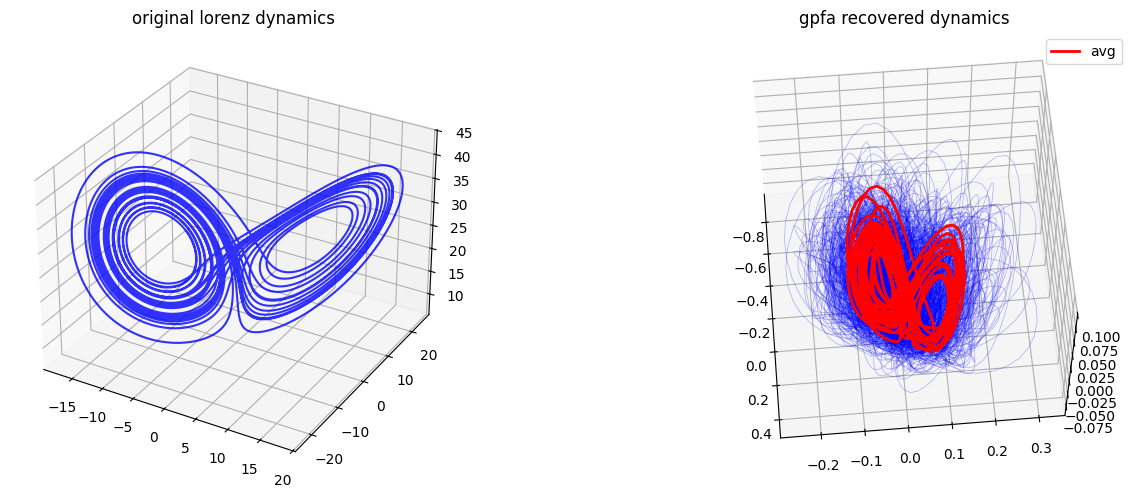

In [ ]:
# compare original vs recovered trajectories
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': '3d'})

# original trajectory
ax1.set_title('original lorenz dynamics')
ax1.plot(lorenz_3d[0, num_steps_transient:],
         lorenz_3d[1, num_steps_transient:],
         lorenz_3d[2, num_steps_transient:], 'b-', alpha=0.8)

# recovered trajectory
ax2.set_title('gpfa recovered dynamics')
for traj in trajectories:
    ax2.plot(traj[0], traj[1], traj[2], 'b-', alpha=0.3, linewidth=0.5)

# trial average
avg_traj = np.mean(trajectories, axis=0)
ax2.plot(avg_traj[0], avg_traj[1], avg_traj[2], 'r-', linewidth=2, label='avg')
ax2.legend()
ax2.view_init(azim=-5, elev=60)  # an optimal viewing angle

plt.tight_layout()
plt.show()

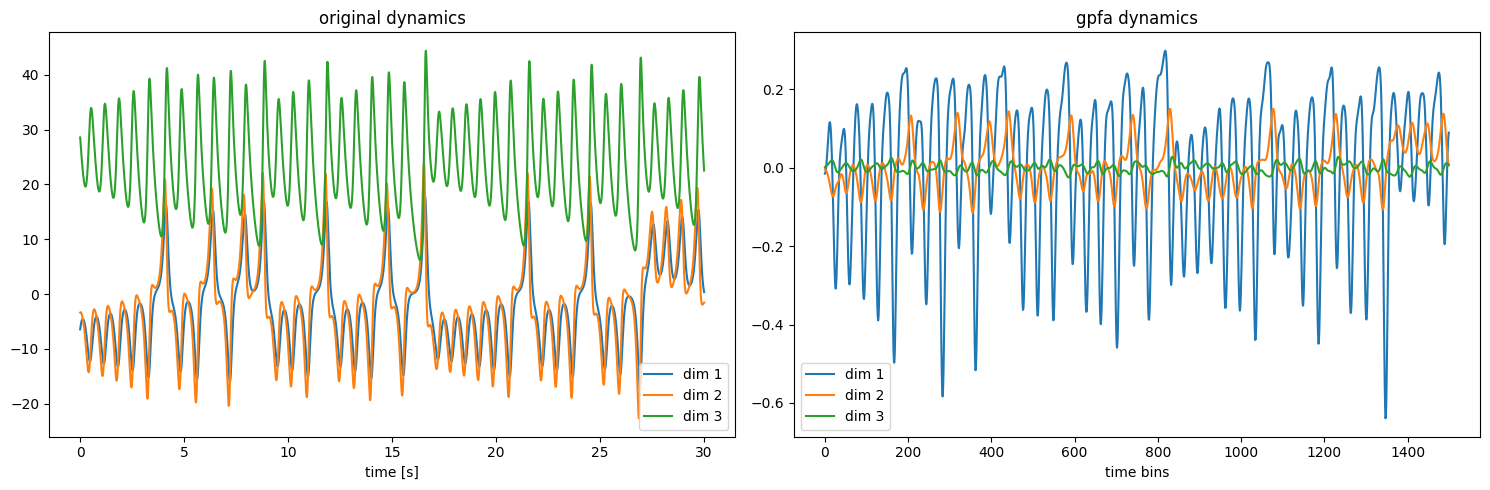

In [7]:
# time series comparison
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title('original dynamics')
ax1.set_xlabel('time [s]')
for i, x in enumerate(lorenz_3d[:, num_steps_transient:]):
    ax1.plot(times_trial, x, label=f'dim {i+1}')
ax1.legend()

ax2.set_title('gpfa dynamics')
ax2.set_xlabel('time bins')
for i, x in enumerate(avg_traj):
    ax2.plot(x, label=f'dim {i+1}')
ax2.legend()

plt.tight_layout()
plt.show()

## Some Extensions

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 440 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 440 EM iterations.)
Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 390 EM iterations.)
dim 1: log likelihood = 261385.28
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
dim 2: log likelihood = 261627.69
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using factor analysis...

Fitting GPFA model...
dim 3: log likelihood = 261620.35
Initializing parameters using factor analysis...

Fitting GPFA model...
Initializing parameters using fact

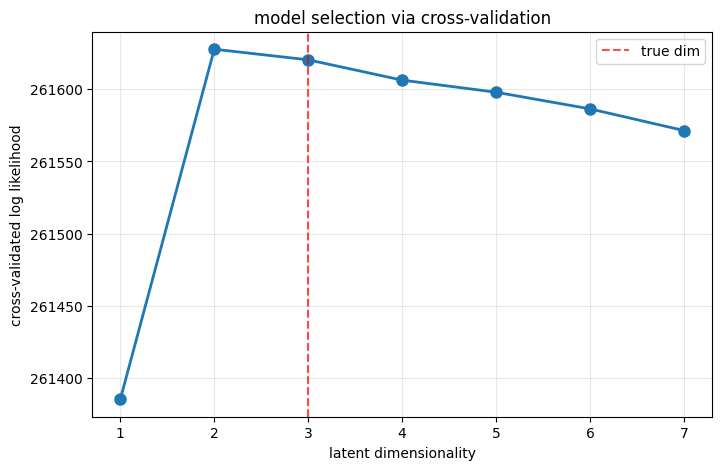

\noptimal dimensionality: 2


In [ ]:
# EXTENSION 1: cross-validation for dimensionality selection
x_dims = [1, 2, 3, 4, 5, 6, 7]
log_likelihoods = []

for x_dim in x_dims:
    gpfa_cv = GPFA(x_dim=x_dim, bin_size=bin_size)
    cv_scores = cross_val_score(gpfa_cv, spiketrains_lorenz, cv=3, n_jobs=1)
    log_likelihoods.append(np.mean(cv_scores))
    print(f'dim {x_dim}: log likelihood = {log_likelihoods[-1]:.2f}')

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x_dims, log_likelihoods, 'o-', linewidth=2, markersize=8)
plt.xlabel('latent dimensionality')
plt.ylabel('cross-validated log likelihood')
plt.title('model selection via cross-validation')
plt.grid(True, alpha=0.3)
plt.axvline(x=3, color='r', linestyle='--', alpha=0.7, label='true dim')
plt.legend()
plt.show()

optimal_dim = x_dims[np.argmax(log_likelihoods)]
print(f'\noptimal dimensionality: {optimal_dim}')

Initializing parameters using factor analysis...

Fitting GPFA model...
noise level 0.00: reconstruction error = 0.029
Initializing parameters using factor analysis...

Fitting GPFA model...
noise level 0.05: reconstruction error = 0.035
Initializing parameters using factor analysis...

Fitting GPFA model...
noise level 0.10: reconstruction error = 0.033
Initializing parameters using factor analysis...

Fitting GPFA model...
noise level 0.20: reconstruction error = 0.032
Initializing parameters using factor analysis...

Fitting GPFA model...
noise level 0.30: reconstruction error = 0.038


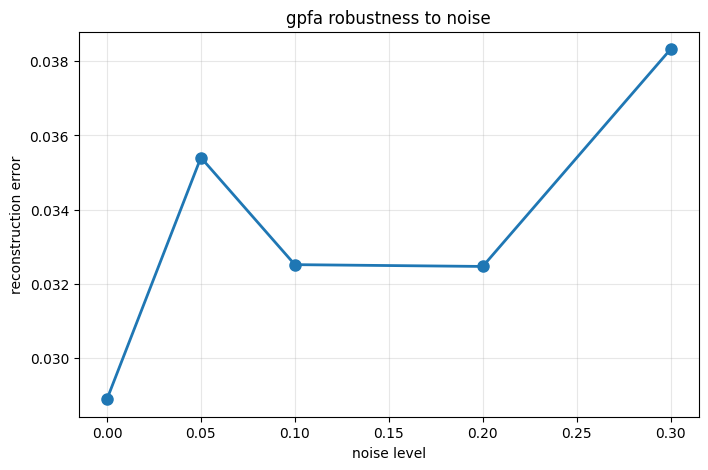

In [9]:
# EXTENSION 2: noise analysis and robustness
def add_noise_to_rates(rates, noise_level=0.1):
    """add gaussian noise to firing rates"""
    noise = np.random.normal(0, noise_level * rates.std(), rates.shape)
    return np.maximum(rates + noise, 0)  # ensure non-negative rates

# test different noise levels
noise_levels = [0, 0.05, 0.1, 0.2, 0.3]
reconstruction_errors = []

for noise_level in noise_levels:
    # add noise to rates
    noisy_rates = add_noise_to_rates(rates_lorenz, noise_level)
    
    # generate new spike trains
    noisy_trains = generate_spiketrains(noisy_rates, num_trials, timestep)
    
    # fit gpfa
    gpfa_noise = GPFA(bin_size=bin_size, x_dim=3)
    noisy_trajectories = gpfa_noise.fit_transform(noisy_trains)
    
    # compute reconstruction error
    avg_noisy = np.mean(noisy_trajectories, axis=0)
    error = np.mean(np.linalg.norm(avg_traj - avg_noisy, axis=0))
    reconstruction_errors.append(error)
    
    print(f'noise level {noise_level:.2f}: reconstruction error = {error:.3f}')

# plot noise robustness
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, reconstruction_errors, 'o-', linewidth=2, markersize=8)
plt.xlabel('noise level')
plt.ylabel('reconstruction error')
plt.title('gpfa robustness to noise')
plt.grid(True, alpha=0.3)
plt.show()

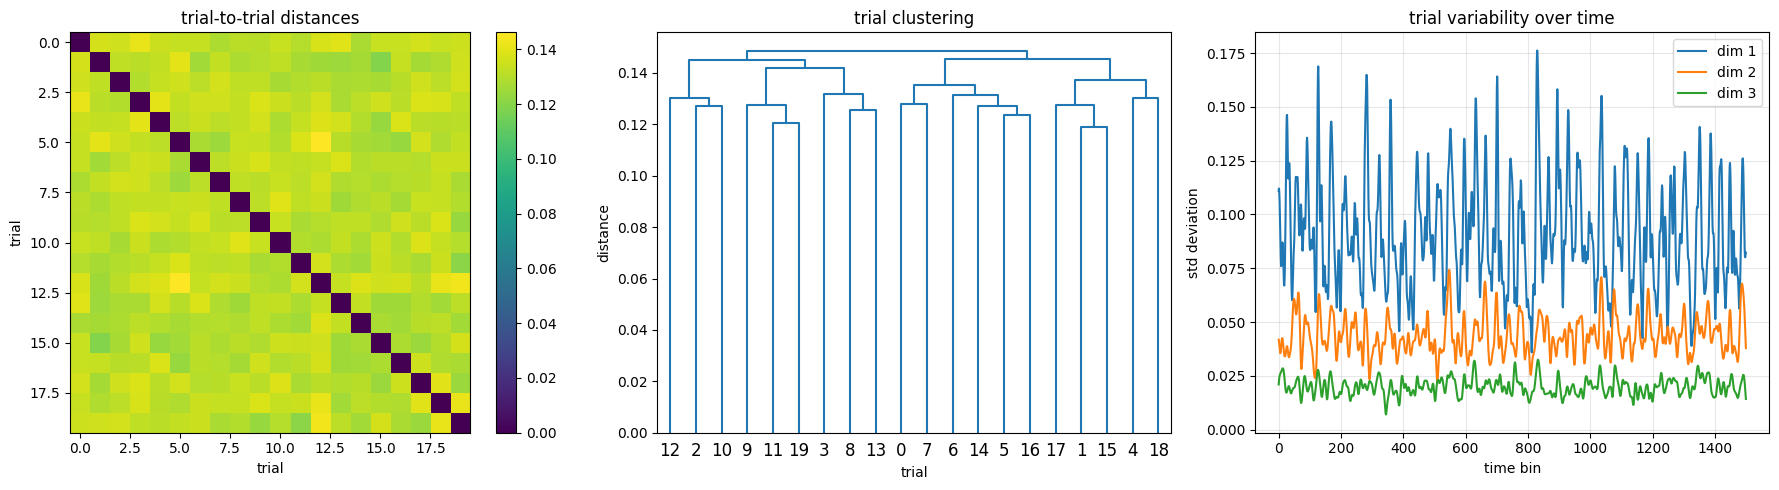

mean trial-to-trial distance: 0.132
std trial-to-trial distance: 0.004


In [10]:
# EXTENSION 3: trial-to-trial variability analysis
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# compute pairwise distances between trials
trial_distances = []
for i in range(len(trajectories)):
    for j in range(i+1, len(trajectories)):
        # compute average distance between trajectories
        dist = np.mean(np.linalg.norm(trajectories[i] - trajectories[j], axis=0))
        trial_distances.append(dist)

# create distance matrix
n_trials = len(trajectories)
dist_matrix = squareform(trial_distances)

# hierarchical clustering
linkage_matrix = linkage(trial_distances, method='ward')

# plot trial similarity
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# distance matrix heatmap
im = ax1.imshow(dist_matrix, cmap='viridis')
ax1.set_title('trial-to-trial distances')
ax1.set_xlabel('trial')
ax1.set_ylabel('trial')
plt.colorbar(im, ax=ax1)

# dendrogram
dendrogram(linkage_matrix, ax=ax2)
ax2.set_title('trial clustering')
ax2.set_xlabel('trial')
ax2.set_ylabel('distance')

# variability across time
trial_std = np.std(trajectories, axis=0)
time_bins = np.arange(trial_std.shape[1])

for i in range(3):
    ax3.plot(time_bins, trial_std[i], label=f'dim {i+1}')
ax3.set_title('trial variability over time')
ax3.set_xlabel('time bin')
ax3.set_ylabel('std deviation')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'mean trial-to-trial distance: {np.mean(trial_distances):.3f}')
print(f'std trial-to-trial distance: {np.std(trial_distances):.3f}')

Initializing parameters using factor analysis...

Fitting GPFA model...


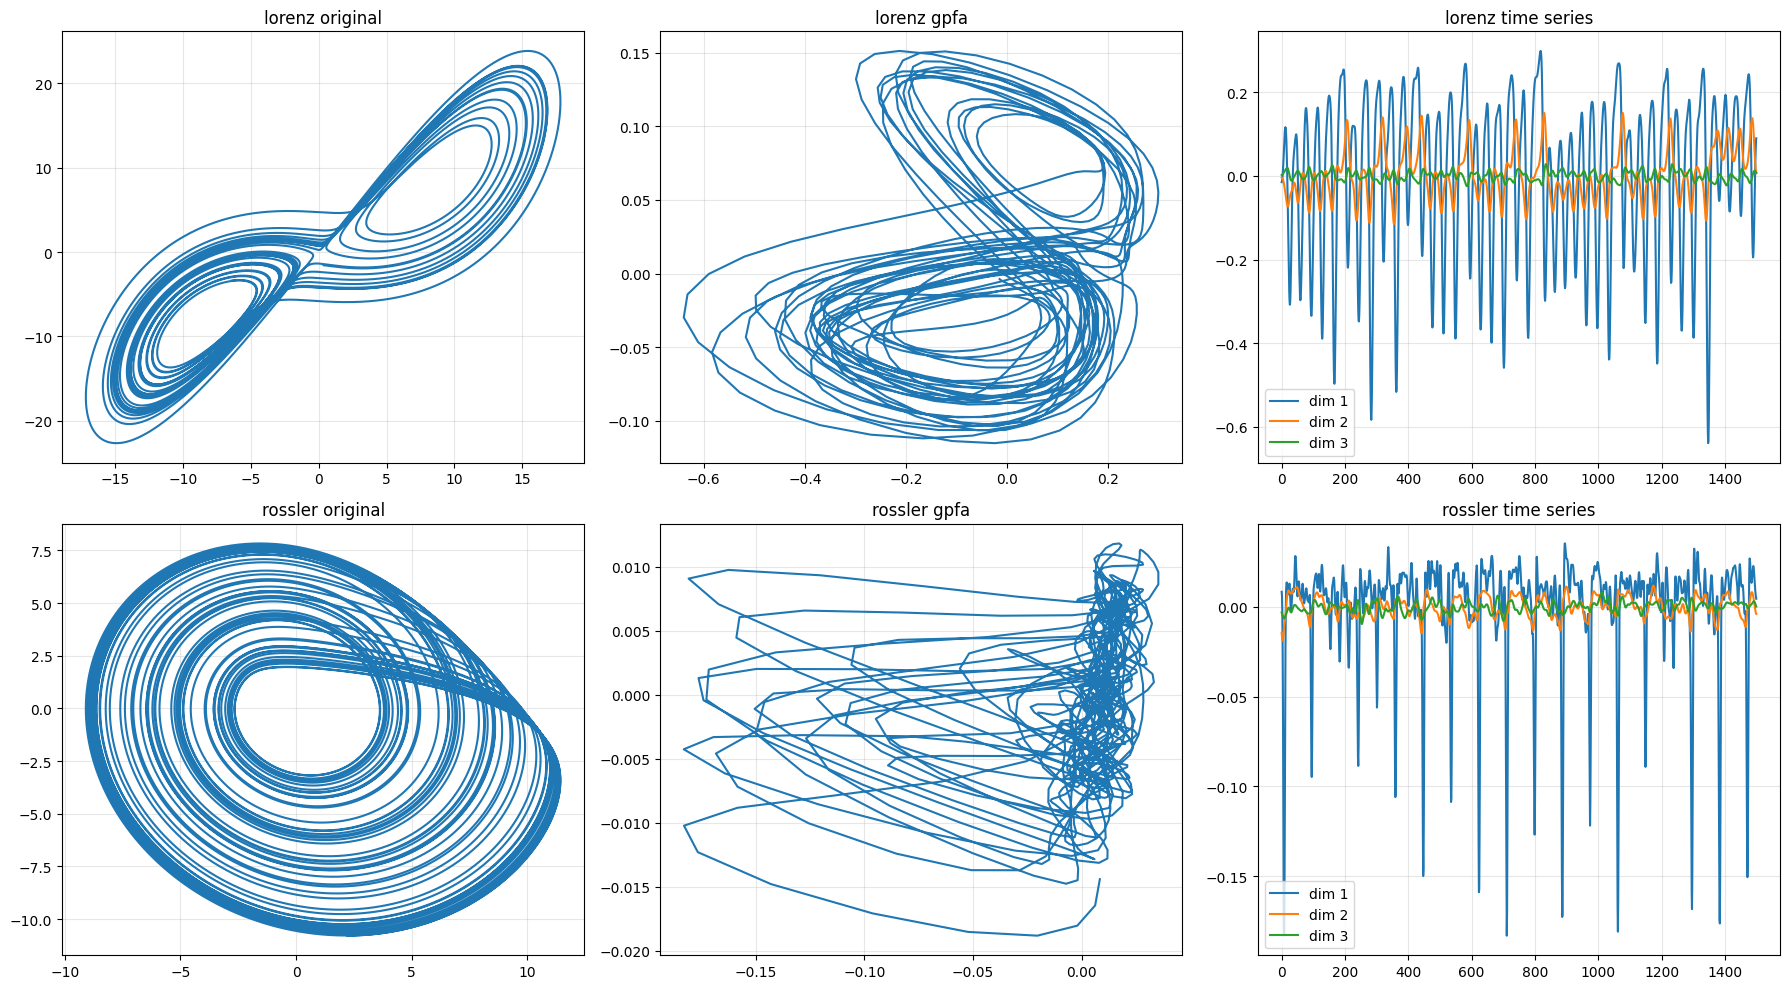

In [11]:
# EXTENSION 4: different dynamical systems comparison
def rossler_system(dt, num_steps, x0=0, y0=0, z0=0, a=0.2, b=0.2, c=5.7, tau=1e2):
    """integrate rossler attractor"""
    def _rossler_ode(point, t, a, b, c, tau):
        x, y, z = point
        x_dot = (-y - z) / tau
        y_dot = (x + a*y) / tau  
        z_dot = (b + z*(x - c)) / tau
        return x_dot, y_dot, z_dot
    t = dt * np.arange(num_steps)
    trajectory = odeint(_rossler_ode, (x0, y0, z0), t, args=(a, b, c, tau))
    return t, trajectory.T

# generate rossler data
times_ross, rossler_3d = rossler_system(
    timestep, num_steps=num_steps_transient+num_steps,
    x0=1, y0=0, z0=0
)

# project and generate spikes
rossler_nd = random_projection(rossler_3d[:, num_steps_transient:], num_spiketrains)
normed_ross = rossler_nd / np.abs(rossler_nd).max()
rates_ross = np.power(max_rate.magnitude, np.abs(normed_ross))
spiketrains_ross = generate_spiketrains(rates_ross, num_trials, timestep)

# fit gpfa to rossler data
gpfa_ross = GPFA(bin_size=bin_size, x_dim=3)
trajectories_ross = gpfa_ross.fit_transform(spiketrains_ross)
avg_ross = np.mean(trajectories_ross, axis=0)

# compare systems
f, axes = plt.subplots(2, 3, figsize=(18, 10))

# original dynamics
axes[0,0].set_title('lorenz original')
axes[0,0].plot(lorenz_3d[0, num_steps_transient:], lorenz_3d[1, num_steps_transient:])

axes[1,0].set_title('rossler original') 
axes[1,0].plot(rossler_3d[0, num_steps_transient:], rossler_3d[1, num_steps_transient:])

# gpfa reconstructions
axes[0,1].set_title('lorenz gpfa')
axes[0,1].plot(avg_traj[0], avg_traj[1])

axes[1,1].set_title('rossler gpfa')
axes[1,1].plot(avg_ross[0], avg_ross[1])

# time series
axes[0,2].set_title('lorenz time series')
for i in range(3):
    axes[0,2].plot(avg_traj[i], label=f'dim {i+1}')
axes[0,2].legend()

axes[1,2].set_title('rossler time series')
for i in range(3):
    axes[1,2].plot(avg_ross[i], label=f'dim {i+1}')
axes[1,2].legend()

for ax in axes.flat:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()